In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from einops import rearrange, repeat
from scipy.linalg import sqrtm
from scipy import integrate
from functools import partial

from mpl_toolkits.mplot3d import Axes3D

from models.mlp import CFGResNet

### **Embeddings**

#### why embedding is needed:
https://datascience.stackexchange.com/questions/85855/why-transform-embedding-dimension-in-sin-cos-positional-encoding

A multi-head attention layer of the Transformer architecture performs computations that are position-independent. This means that, if the same inputs are received at two different positions, the attention heads in the layer would return the same value at the two positions.
(Attention module not implemented yet)

#### What should positional embeddings do?
https://harrisonpim.com/blog/understanding-positional-embeddings-in-transformer-models

Unlike word embeddings, the characteristics of positional embeddings aren't emergent from data - they can be deliberately constructed to have certain properties. Concisely, positional embeddings should:

* Be reflective of their distances from one another in the sequence - we should be able to use a distance metric to compare vectors, with positionally similar vectors producing small distances, and positionally distant vectors producing large distances in the vector space we construct.

* Have values bounded between 0 and 1 - we’re using these as inputs to a neural network, so well-bounded values are useful.

* Be invariant to sequence length - the values assigned to each position should be the same, whether the text is long or short.

* Be deterministic - they shouldn't change from one initialisation of a network to another.

In [2]:
def to_flattened_numpy(x):
  """Flatten a torch tensor `x` and convert it to numpy."""
  return x.detach().cpu().numpy().reshape((-1,))

def from_flattened_numpy(x, shape):
  """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
  return torch.from_numpy(x.reshape(shape))

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.embed_dim = embed_dim
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    #print('t embed: ', x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

  def __len__(self):
    return self.embed_dim

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = torch.tensor(self.size // 2, device=x.device)
        emb = torch.log(torch.tensor([10000.0], device=x.device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=x.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size

class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1

class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1

class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()
        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)

### **Feature-wise transformations**

https://distill.pub/2018/feature-wise-transformations/

if self.adaptive_scale:

    scale, shift = params.chunk(2, dim=-1)

    x = nn.functional.silu(torch.addcmul(shift, x, scale+1))

Compared to direct concatenation of feature and embedding, the procedure shown above have equivalent struture in theory and don't have to increase the latent space of the model.

### **ResNet config**

The implemented ResNet emulates the struture of the ResNet used in CV, where the conv2D layer in CV is simply replaced by the linear layer. Each ResNet block is equivalent to have 2 MLP layers and a single layer to process the time embedding.

The first and final linear layers are used to map the input to the channel dimension and to map the channel dimension back to the output dimension, respectively.

### **Normalization**
https://gaoxiangluo.github.io/2021/08/01/Group-Norm-Batch-Norm-Instance-Norm-which-is-better/

WIP (not implemented yet), would be helpful when batchdata is not iid (e.g., when the data distribution changes across batches because they may not be from the same distribution, i.e. not identically distributed)

In [3]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_channels, dropout=0,
                 skip_scale=1, adaptive_scale=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        #self.linear1 = nn.Linear(in_channels, out_channels)
        self.linear2 = nn.Linear(out_channels, out_channels)
        self.affine = nn.Linear(emb_channels, out_channels*(2 if adaptive_scale else 1))

    def forward(self, x, emb):
        #print(x.shape, emb.shape)
        orig = x
        #x = self.linear1(nn.functional.silu(x))
        params = nn.functional.silu(self.affine(emb).to(x.dtype))
        if self.adaptive_scale:
            scale, shift = params.chunk(2, dim=-1)
            x = nn.functional.silu(torch.addcmul(shift, x, scale+1))
        else:
            x = nn.functional.silu(x.add_(params))

        x = self.linear2(nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = x.add_(orig)
        x = x * self.skip_scale

        return x

class ResNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels,
                label_dim           = 0,        # Number of class labels, 0 = unconditional.
                augment_dim         = 0,        # Augmentation label dimensionality, 0 = no augmentation.
                model_channels      = 128,      # Channel multiplier.
                channel_mult        = [1,1,1,1],# Channel multiplier for each resblock layer.
                channel_mult_emb    = 4,
                num_blocks          = 4,        # Number of resblocks(mid) per level.
                dropout             = 0.,      # Dropout rate.
                emb_type            = "sinusoidal",# Timestep embedding type
                channel_mult_noise  = 1,        # Time embedding size
                ):

        super().__init__()

        emb_channels = model_channels * channel_mult_emb
        noise_channels = model_channels * channel_mult_noise
        block_kwargs = dict(dropout = dropout, skip_scale=1.0, adaptive_scale=True)

        self.map_noise = PositionalEmbedding(size=noise_channels, type=emb_type)
        self.map_layer = nn.Linear(noise_channels, emb_channels)
        #self.map_layer1 = nn.Linear(emb_channels, emb_channels)

        self.first_layer = nn.Linear(in_channels, model_channels)
        self.blocks = nn.ModuleList()
        cout = model_channels
        for level, mult in enumerate(channel_mult):
            for _ in range(num_blocks):
                cin = cout
                cout = model_channels * mult
                self.blocks.append(ResNetBlock(cin, cout, emb_channels, **block_kwargs))
        self.final_layer = nn.Linear(cout, out_channels)

    def forward(self, x, noise_labels, class_labels=None, augment_labels=None):
        # Mapping
        emb = self.map_noise(noise_labels)
        #emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape) # why swap emb (sin/cos)?
        emb = nn.functional.silu(self.map_layer(emb))
        #emb = nn.functional.silu(self.map_layer1(emb))
        x = self.first_layer(x)
        for block in self.blocks:
            x = block(x, emb)
        x = self.final_layer(nn.functional.silu(x))
        return x

## Score-based modeling

Score-based modeling with SDEs relies on a stochastic process which can be reversed to produce samples from a data distribution. The noising process takes samples from the source (data) distribution, and progressively adds noise according to the dynamics of the SDE. The final distribution should be approximately equal to a prior distribution which does not depend on the data.

Samples can then be drawn from the prior, the reverse SDE simulated, and the final sample is from the data distribution

A simple architecture is implemented here to predict the time-dependent score function.

### **SDEs**

#### **Variance Exploding [VE] SDE**
We define our SDE by

$dx = \sigma^t dw \;, \; t \in [0, 1]$

where $w$ is the Weiner process. This SDE defines a noise schedule which exponentially increases in time, similarly to the annealed variance schedule in discrete time.

Solving the SDE, we have the transition kernel

$p_{0t}(x(t)|x(0)) = \mathcal{N}\left ( x(t); x(0), \frac{1}{2\log \sigma}(\sigma^{2t} -1)I \right )$

With large enough $\sigma$, this means that the prior $p(x(t=1))$ approximately does not depend on the data

$\int p_0(y)p_{01}(y(1)|y(0))dy \approx \mathcal{N}(x; 0, \frac{1}{2\log \sigma}(\sigma^2-1)I)$

To sample, we simulate the reverse-time SDE give by

$dx = -\sigma^{2t}s_\theta(x, t)dt + \sigma^tdw$

An Euler-Maruyama sampling step for this is given by

$x_{t-\Delta t} = x_t + \sigma^{2t}s_\theta(x_t,t)\Delta t + \sigma^t\sqrt{\Delta t} z_t$

where $dw$ is replaced with $z\sim \mathcal{N}(0, \sigma^{2t}\Delta t I)$

We define these functions, the loss function, and an Euler-Maruyama sampler below

#### **Variance Preserving [VP] SDE**

This SDE is shown to be equivalent to the denoising-diffusion probabilistic modeling (DDMP) from Ho et al: https://arxiv.org/pdf/2006.11239.pdf

The SDE form is given by

$dx = -\frac{1}{2}\beta(t)xdt + \sqrt{\beta(t)}dw$

where

$\beta(t) = \beta_{min}+t(\beta_{max}-\beta_{min})$

The transition kernel can then be found from Eq. 5.50 and 5.51 in Simo Sarkka and Arno Solin "Applied stochastic differential equations" to be

$p_{0t}(x(t)|x(0)) = \mathcal{N}\left (x(t);x(0)\exp{\left (-\frac{1}{4}t^2(\beta_{max}-\beta_{min})-\frac{1}{2}t\beta_{min} \right )}, I(1-\exp{\left [ -\frac{1}{2}t^2(\beta_{max}-\beta_{min})-t\beta_{min} \right ])} \right)$

and the prior distribution $p(x(t=1))$ is given approimately by

$p(x(t=1))\approx \mathcal{N}(0, I)$

### **Classifier-free guidance(Not included in this notebook)**
For the reverse-time SDE, replacing the $\nabla_x \log p(x(t))$ term in score matching loss function gives:

$dx = [f(x,t)-g(t)^2\nabla_x \log p(x(t)|\theta)]dt + g(t)dw$

From the weighted classifier free equation we have:

$\log p(x(t)|\theta)  = \gamma \underbrace{\nabla_x \log p(x(t)|\theta)}_{\text{cond. score}} + (1-\gamma)\underbrace{\nabla_x \log p(x(t))}_{\text{uncond. score}}$

In practice, the unconditional score is obtained by conditioning on 'null':

self.null_emb = nn.Parameter(torch.randn(emb_size))

and $(1-\gamma)$ is treated as the probability of dropping condition during training.

The conditional channel (null class for every input when trained in uncon) is not introduced in this notebook because it was found that adding the channel would reduce the performance.

In [4]:
class uncon_VP_1D(nn.Module):
    def __init__(self, 
                 beta_min=1e-4, 
                 beta_max=1.0):
        super().__init__()

        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta(self, t):
        return self.beta_min + t*(self.beta_max - self.beta_min)

    def eps(self, noise, score, t, r):
        # used for corrector step in predictor-corrector methods
        alpha = 1 - self.beta(t)
        noise_norm = torch.linalg.norm(noise.reshape((noise.shape[0], -1)), dim=-1).mean()
        score_norm = torch.linalg.norm(score.reshape((score.shape[0], -1)), dim=-1).mean()
        eps = 2*alpha*(r*noise_norm/score_norm)**2
        return eps[:, None]

    def f(self, x, t):
        return -0.5*self.beta(t)[:, None]*x

    def g(self, t):
        return torch.sqrt(self.beta(t))[:, None]

    def q_mu(self, x0, t):
        return x0*torch.exp(-0.25*t**2*(self.beta_max-self.beta_min)-0.5*t*self.beta_min)[:, None]

    def q_std(self, x0, t):
        return torch.sqrt(1-torch.exp(-0.5*t**2*(self.beta_max-self.beta_min)-t*self.beta_min))[:, None]

    def forward(self, x0, t):
        # forward SDE transition kernel. Return noisy sample, noise, and standard deviation
        z = torch.randn_like(x0)
        std = self.q_std(x0, t)
        mu = self.q_mu(x0, t)
        return mu + z*std, std, z

    def sample_prior(self, data_size, device):
        return torch.randn(data_size, device=device)
    
    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1)) / 2.
        return logps

class uncon_EulerMaruyama(nn.Module):
    def __init__(self, 
                 num_time_steps=500, 
                 eps=1e-7,
                 intermediate_steps=100000):
        super().__init__()

        self.num_time_steps = num_time_steps
        self.eps = eps
        self.intermediate_steps = intermediate_steps

    @torch.no_grad()
    def predictor_step(self, x, t, step_size, unet, sde, device):
        mean_x = x - (sde.f(x, t) - sde.g(t)**2*unet(x, t))*step_size
        x = mean_x + torch.sqrt(step_size)*sde.g(t)*torch.randn_like(x)
        return x, mean_x

    @torch.no_grad()
    def forward(self, unet, sde, data_size, device, return_intermediates=False):
        batch_size = data_size[0]
        noise = sde.sample_prior(data_size, device=device)
        time_steps = torch.linspace(1., self.eps, self.num_time_steps, device=device)
        step_size = time_steps[0]-time_steps[1]

        x = noise + 0.
        intermediates = []
        i = 1
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            x, mean_x = self.predictor_step(x, batch_time_step, step_size, unet, sde, device)
            if i % self.intermediate_steps == 0:
                intermediates.append(x)
            i += 1

        # no noise in last step
        return mean_x, intermediates

class ODE_uncon_EulerMaruyama(nn.Module):
    def __init__(self,
                 num_time_steps=500, 
                 eps=1e-7,
                 intermediate_steps=100000,
                 rtol = 1e-5,
                 atol = 1e-5,
                 method = 'RK45'):
        super().__init__()

        self.num_time_steps = num_time_steps
        self.eps = eps
        self.intermediate_steps = intermediate_steps
        self.rtol = rtol
        self.atol = atol
        self.method = method

    @torch.no_grad()
    def forward(self, score_model, sde, data_size, device, return_intermediates=False):
        
        def ode_func(t, x):        
            """The ODE function for use by the ODE solver."""
            x = from_flattened_numpy(x, shape).to(device).type(torch.float32)
            vec_t = torch.ones(shape[0], device=x.device) * t  
            #print(x.shape, vec_t.shape)
            g = sde.g(vec_t)
            f = sde.f(x, vec_t)
            #print(g.shape, f.shape)
            return to_flattened_numpy(f -0.5 * (g**2) * score_model(x, vec_t))

        #batch_size = data_size[0]
        noise = sde.sample_prior(data_size, device=device)
        #time_steps = torch.linspace(1., self.eps, self.num_time_steps, device=device)
        #step_size = time_steps[0]-time_steps[1]
        #c = torch.zeros((batch_size, score_model.cond_size), device=device)
        #context_mask = torch.zeros_like(c)

        x = noise + 0.
        shape = x.shape
        intermediates = []
        
        # Run the black-box ODE solver.
        res = integrate.solve_ivp(ode_func, (1., self.eps), to_flattened_numpy(x), rtol=self.rtol, atol=self.atol, method=self.method)  
        print(f"Number of function evaluations: {res.nfev}")
        x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

        # no noise in last step
        return x, intermediates

### **Likelihood computation**

Ref: Appendix D, SDE paper
More details:https://arxiv.org/pdf/1705.07057.pdf, P12

$dx = \underbrace{\left( f(x,t) - \frac{1}{2}\nabla\cdot\left[G(x,t)G(x,t)^T\right]-\frac{1}{2}G(x,t)G(x,t)^T s_\theta (x,t)\right)}_{=:\tilde{f_\theta}(x,t)}dt $

with the change of varibales formula, the log likelihood $p_0(x)$ can be computed as:

$\log p_0(x(0)) = \log_{p_T}(x(T)) + \int_0^T \nabla\cdot\tilde{f_\theta}(x(t),t)dt $

Computating $\nabla\cdot\tilde{f_\theta}(x(t),t)$ is expensive, estimate it with:

$\nabla\cdot\tilde{f_\theta}(x(t),t) = \mathbb{E}_{p(\epsilon)}[\epsilon^T\nabla\tilde{f_\theta}(x(t),t)\epsilon]$

Where $\nabla\tilde{f_\theta}$ denote the Jacobian of $\tilde{f_\theta}(\cdot,t)$, and the random variable $\epsilon$ satisfies $\mathbb{E}_{p(\epsilon)}[\epsilon]=0$ and $Cov_{p(\epsilon)}[\epsilon]=I$

In [5]:
def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn

def get_likelihood_fn(sde, inverse_scaler, hutchinson_type='Rademacher',
                      rtol=1e-5, atol=1e-5, method='RK45', eps=1e-5):
  """Create a function to compute the unbiased log-likelihood estimate of a given data point.

  Args:
    sde: A `sde_lib.SDE` object that represents the forward SDE.
    inverse_scaler: The inverse data normalizer.
    hutchinson_type: "Rademacher" or "Gaussian". The type of noise for Hutchinson-Skilling trace estimator.
    rtol: A `float` number. The relative tolerance level of the black-box ODE solver.
    atol: A `float` number. The absolute tolerance level of the black-box ODE solver.
    method: A `str`. The algorithm for the black-box ODE solver.
      See documentation for `scipy.integrate.solve_ivp`.
    eps: A `float` number. The probability flow ODE is integrated to `eps` for numerical stability.

  Returns:
    A function that a batch of data points and returns the log-likelihoods in bits/dim,
      the latent code, and the number of function evaluations cost by computation.
  """

  def drift_fn(score_model, x, t):
    """The drift function of the reverse-time SDE."""
    # Probability flow ODE is a special case of Reverse SDE
    g = sde.g(t)
    f = sde.f(x, t)
    return f - 0.5*g**2 * score_model(x, t) 

  def div_fn(model, x, t, noise):
    return get_div_fn(lambda xx, tt: drift_fn(model, xx, tt))(x, t, noise)

  def likelihood_fn(model, data):
    """Compute an unbiased estimate to the log-likelihood in bits/dim.

    Args:
      model: A score model.
      data: A PyTorch tensor.

    Returns:
      bpd: A PyTorch tensor of shape [batch size]. The log-likelihoods on `data` in bits/dim.
      z: A PyTorch tensor of the same shape as `data`. The latent representation of `data` under the
        probability flow ODE.
      nfe: An integer. The number of function evaluations used for running the black-box ODE solver.
    """
    with torch.no_grad():
      shape = data.shape
      if hutchinson_type == 'Gaussian':
        epsilon = torch.randn_like(data)
      elif hutchinson_type == 'Rademacher':
        epsilon = torch.randint_like(data, low=0, high=2).float() * 2 - 1.
      else:
        raise NotImplementedError(f"Hutchinson type {hutchinson_type} unknown.")

      def ode_func(t, x):
        sample = from_flattened_numpy(x[:-shape[0]], shape).to(data.device).type(torch.float32)
        vec_t = torch.ones(sample.shape[0], device=sample.device) * t
        drift = to_flattened_numpy(drift_fn(model, sample, vec_t))
        logp_grad = to_flattened_numpy(div_fn(model, sample, vec_t, epsilon))
        return np.concatenate([drift, logp_grad], axis=0)

      init = np.concatenate([to_flattened_numpy(data), np.zeros((shape[0],))], axis=0)
      solution = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=rtol, atol=atol, method=method)
      nfe = solution.nfev
      zp = solution.y[:, -1]
      z = from_flattened_numpy(zp[:-shape[0]], shape).to(data.device).type(torch.float32)
      delta_logp = from_flattened_numpy(zp[-shape[0]:], (shape[0],)).to(data.device).type(torch.float32)
      prior_logp = sde.prior_logp(z)
      nll = -prior_logp - delta_logp
      '''
      bpd = -(prior_logp + delta_logp) / np.log(2)
      N = np.prod(shape[1:])
      bpd = bpd / N
      # A hack to convert log-likelihoods to bits/dim
      offset = 7. - inverse_scaler(-1.)
      offset = 0
      bpd = bpd + offset
      '''
      return nll, z, nfe

  return likelihood_fn

In [6]:
def plot_distribution(xedges, yedges, histogram1, histogram2, hist_range):
    # Plot histogram for samp1
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    X, Y = np.meshgrid(xedges[:-1] + 0.08, yedges[:-1] + 0.08)
    plt.pcolormesh(X, Y, histogram1)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(hist_range[0])
    plt.ylim(hist_range[1])

    # Plot contour for samp1
    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, histogram1)
    plt.colorbar()
    plt.title('Generated PDF')
    plt.axis('equal')
    plt.xlim(hist_range[0])
    plt.ylim(hist_range[1])

    # Plot histogram for true data
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, histogram2)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(hist_range[0])
    plt.ylim(hist_range[1])

    # Plot contour for true data
    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, histogram2)
    plt.colorbar()
    plt.title('True PDF')
    plt.axis('equal')
    plt.xlim(hist_range[0])
    plt.ylim(hist_range[1])

    # Calculate and plot the difference between the true and generated PDF
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, histogram2 - histogram1, cmap='viridis')
    plt.title('True-Generated PDF')
    plt.colorbar(surf)
    plt.show()

def get_KLD(samp1=None, dat=None):
    # Load the data
    if samp1 is None and dat is None:
        samp1 = np.loadtxt('samples.out')
        dat = np.loadtxt('true_dat.out')

    # Parameters for the histogram
    bins = np.arange(-4, 4 + 0.16, 0.16)
    hist_range = [[-3, 3], [-3, 3]]
    histogram1, xedges, yedges = np.histogram2d(samp1[:, 0], samp1[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for samp1
    entropy_samp1 = -np.sum(histogram1 * np.log(histogram1 + 1.e-20)) * 0.16 * 0.16

    histogram2, _, _ = np.histogram2d(dat[:, 0], dat[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for true data
    entropy_dat = -np.sum(histogram2 * np.log(histogram2 + 1.e-20)) * 0.16 * 0.16

    # Flatten the histograms for KLD calculation
    flat_pdf_true = histogram2.flatten() + 1.e-20
    flat_pdf_gen = histogram1.flatten() + 1.e-20

    # Calculate the KLD
    KLD = np.sum(flat_pdf_true * np.log(flat_pdf_true / flat_pdf_gen)) * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
    print('KLD: ', KLD)
    #plot_distribution(xedges, yedges, histogram1, histogram2, hist_range)
    return KLD, entropy_samp1, entropy_dat

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


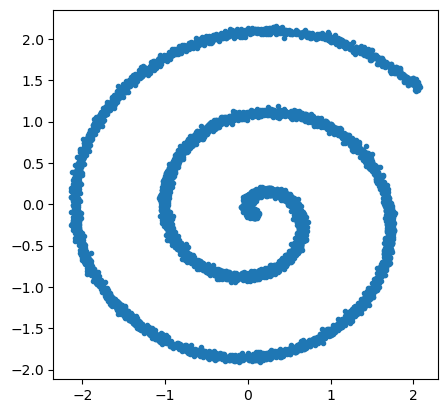

In [7]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

def p_losses(score_model, sde, x0):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

def p_losses_cond(score_model, sde, x0, c):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t, c)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

seed_everything(0)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = 8192

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
generator = torch.Generator().manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

The script below shows tuning of hyperparameter, as the beta follows a linear scheduling, the tuning focus on beta_max because the initial perturbation is relatively small, i.e., results obtained from beta_min 1E-4 and 1E-5 wouldn't make a large difference.

In [8]:
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]

device='cuda'
output_step = 100

#beta_min_values = np.logspace(-8, -2, num=7) 
beta_min_values = np.array([1e-4])
#beta_max_values = np.hstack((np.array([1]),np.linspace(10, 100, num=10)))
beta_max_values = np.array([0.1, 0.5, 1., 5., 10., 15., 20., 30.])
last_loss_values = []
fid_values = []
avg_nll_values = []
for beta_min in beta_min_values:
    for beta_max in beta_max_values:
        seed_everything(0)
        vp = uncon_VP_1D(beta_min, beta_max)

        model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                        channel_mult=[1,1,1,1,1,1], channel_mult_emb=1, num_blocks=2,
                        dropout=0, emb_type="sinusoidal", channel_mult_noise=1)
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses(model, vp, x)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            if epoch % output_step == 0:
                print('beta_max: ', beta_max, ' beta_min: ', beta_min, ' loss @ epoch '+str(epoch)+': ', avg_loss / num_items)
        torch.save(model.state_dict(), 'mdl_weights/'+str(beta_min)+'_'+str(beta_max)+'.pth')
        print('beta_max: ', beta_max, ' beta_min: ', beta_min, ' last_loss: ', avg_loss / num_items)

        last_loss = avg_loss / num_items
        vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
        #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
        samples, _ = vp_sampler(model, vp, train_data.shape, device)
        #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
        samples = samples.detach().cpu().numpy()
        fid = fid_metric(samples, train_data.detach().cpu().numpy())
        inverse_scaler = 1 # dummy param
        likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
        nll = likelihood_fn(model, train_data.to(device))[0]
        nll = nll.detach().cpu().numpy()
        avg_nll = np.mean(nll)
        avg_weighted_nll = np.mean(nll*np.exp(nll))
        
        last_loss_values.append(last_loss)
        fid_values.append(fid)
        avg_nll_values.append(avg_nll)

training ...
beta_max:  0.1  beta_min:  0.0001  loss @ epoch 0:  1.9780524978414178
beta_max:  0.1  beta_min:  0.0001  loss @ epoch 100:  1.2242647670209408
beta_max:  0.1  beta_min:  0.0001  loss @ epoch 200:  1.2267841913271695
beta_max:  0.1  beta_min:  0.0001  loss @ epoch 300:  1.227417829213664
beta_max:  0.1  beta_min:  0.0001  loss @ epoch 400:  1.2436742829158902
beta_max:  0.1  beta_min:  0.0001  last_loss:  1.2047466402873397
training ...
beta_max:  0.5  beta_min:  0.0001  loss @ epoch 0:  1.8547133542597294
beta_max:  0.5  beta_min:  0.0001  loss @ epoch 100:  1.4130117357708514
beta_max:  0.5  beta_min:  0.0001  loss @ epoch 200:  1.4163517402485013
beta_max:  0.5  beta_min:  0.0001  loss @ epoch 300:  1.381020765285939
beta_max:  0.5  beta_min:  0.0001  loss @ epoch 400:  1.426616198150441
beta_max:  0.5  beta_min:  0.0001  last_loss:  1.3863880564458668
training ...
beta_max:  1.0  beta_min:  0.0001  loss @ epoch 0:  1.7248980081640184
beta_max:  1.0  beta_min:  0.0001  

In [9]:
model

ResNet(
  (map_noise): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (map_layer): Linear(in_features=128, out_features=128, bias=True)
  (first_layer): Linear(in_features=2, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x ResNetBlock(
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (affine): Linear(in_features=128, out_features=256, bias=True)
    )
  )
  (final_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [10]:
import pandas as pd

results_df = pd.DataFrame({
    'beta_min': np.repeat(beta_min_values, len(beta_max_values)),
    'beta_max': np.tile(beta_max_values, len(beta_min_values)),
    'last_loss': last_loss_values,
    'fid': fid_values,
    'avg_nll': avg_nll_values
})

print(results_df)

   beta_min  beta_max  last_loss       fid   avg_nll
0    0.0001       0.1   1.204747  0.002863  1.002240
1    0.0001       0.5   1.386388  0.000798  0.666123
2    0.0001       1.0   1.381530  0.000401  0.761896
3    0.0001       5.0   0.954617  0.003014  0.723777
4    0.0001      10.0   0.696640  0.002947  0.934599
5    0.0001      15.0   0.568057  0.002098  1.008963
6    0.0001      20.0   0.492669  0.001710  1.089842
7    0.0001      30.0   0.400083  0.002627  1.141731


In [11]:
#results_df.to_csv("results.csv", index=False)
#results_df = pd.read_csv("results.csv")

In [16]:
# load pretrained
#'''
beta_max = 0.5
beta_min = 0.0001
model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                channel_mult=[1,1,1,1,1,1], channel_mult_emb=1, num_blocks=2,
                dropout=0, emb_type="sinusoidal", channel_mult_noise=1)
model.eval()
model.to(device)
model.load_state_dict(torch.load('mdl_weights/0.0001_0.5.pth'))
vp = uncon_VP_1D(beta_min, beta_max)
#'''

In [17]:
vp = uncon_VP_1D(beta_min, beta_max)
vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
samples, _ = vp_sampler(model, vp, train_data.shape, device)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

In [18]:
print(beta_min, beta_max)

0.0001 0.5


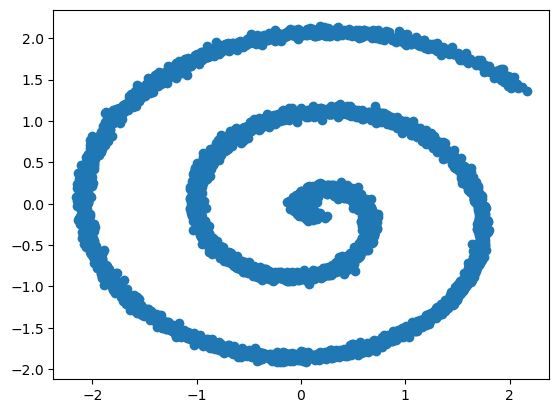

In [19]:
plt.scatter(samples[:,0], samples[:,1])
#plt.xlim((-5,5))
#plt.ylim((-5,5))

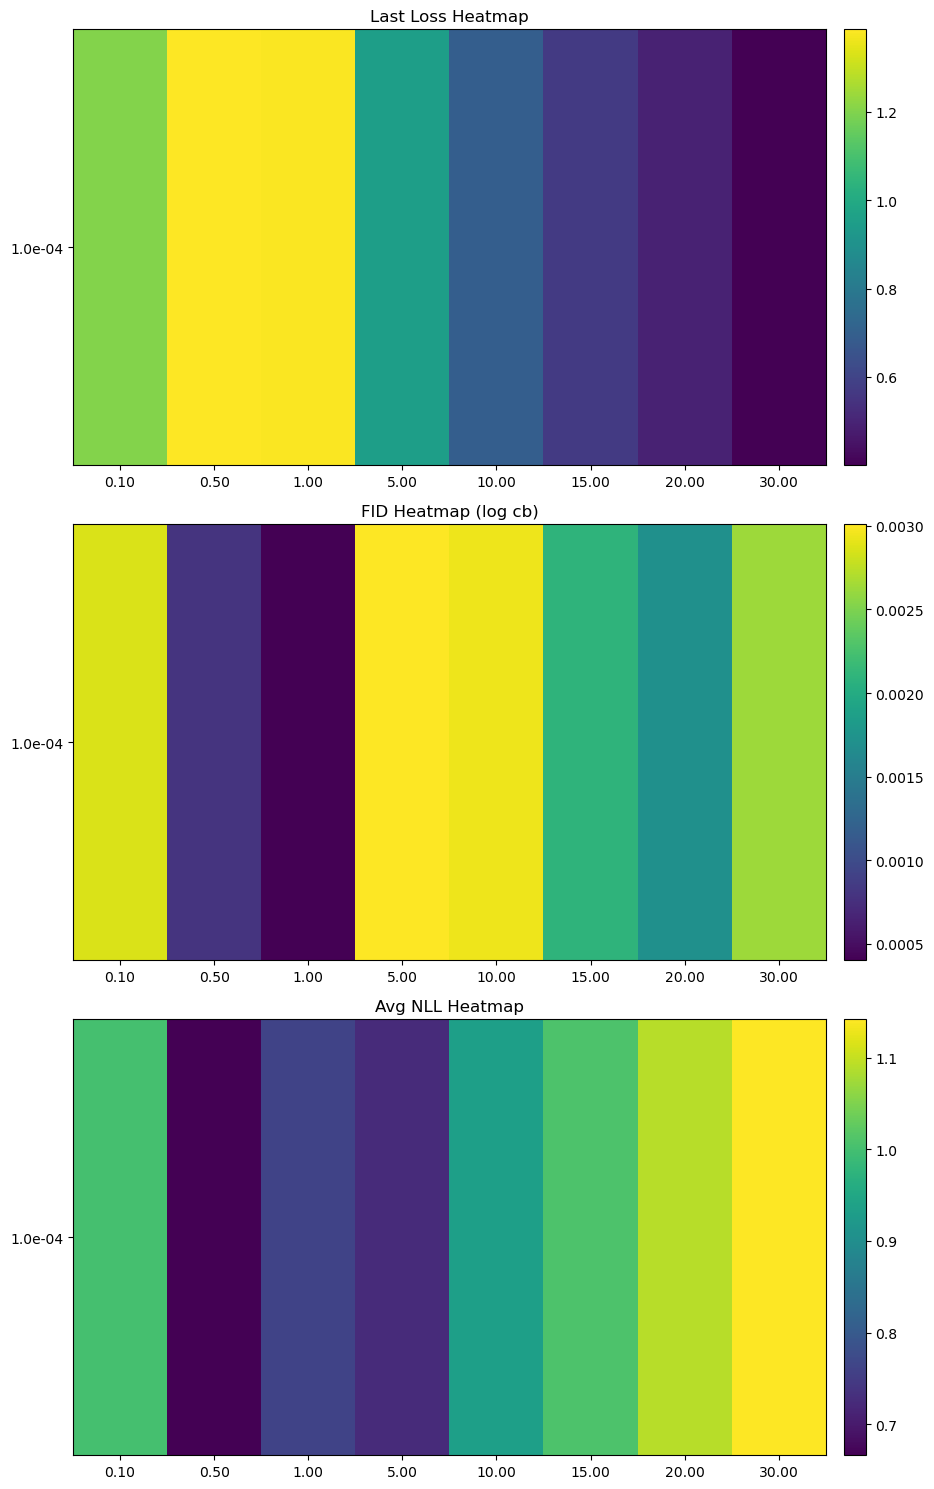

In [20]:
# Reshape columns to matrix form for heatmap
last_loss_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='last_loss').values
fid_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='fid').values
avg_nll_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='avg_nll').values
log_fid_matrix = np.log1p(fid_matrix)

# Plotting heatmaps
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Last Loss heatmap
cax1 = ax[0].imshow(last_loss_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Last Loss Heatmap')
ax[0].set_xticks(np.arange(len(beta_max_values)))
ax[0].set_yticks(np.arange(len(beta_min_values)))
ax[0].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[0].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax1, ax=ax[0], orientation='vertical', pad=0.02)

# FID heatmap
cax2 = ax[1].imshow(log_fid_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('FID Heatmap (log cb)')
ax[1].set_xticks(np.arange(len(beta_max_values)))
ax[1].set_yticks(np.arange(len(beta_min_values)))
ax[1].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[1].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax2, ax=ax[1], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[2].imshow(avg_nll_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[2].set_title('Avg NLL Heatmap')
ax[2].set_xticks(np.arange(len(beta_max_values)))
ax[2].set_yticks(np.arange(len(beta_min_values)))
ax[2].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[2].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax3, ax=ax[2], orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

### **Changing train data size**

Model weights loaded successfully, computing last epoch loss.
KLD:  1.3434704839756262


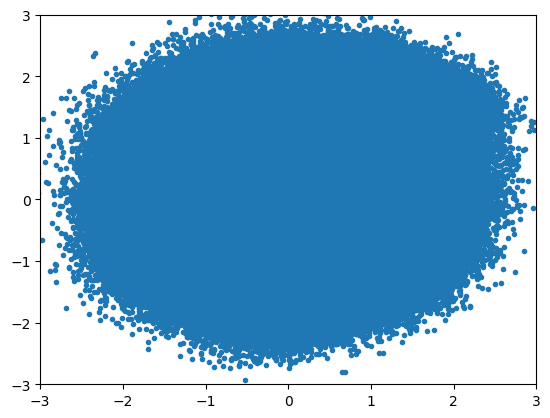

Model weights loaded successfully, computing last epoch loss.
KLD:  0.8181834861524955


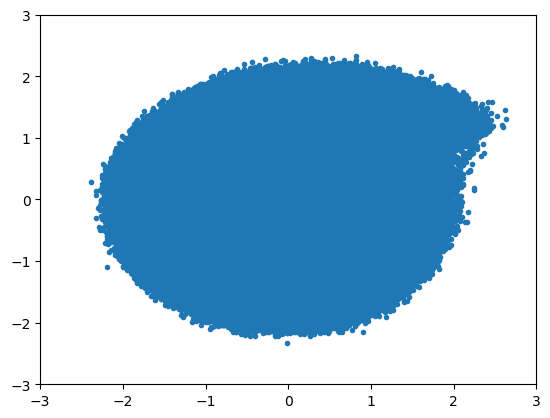

Model weights loaded successfully, computing last epoch loss.
KLD:  0.39194808528100017


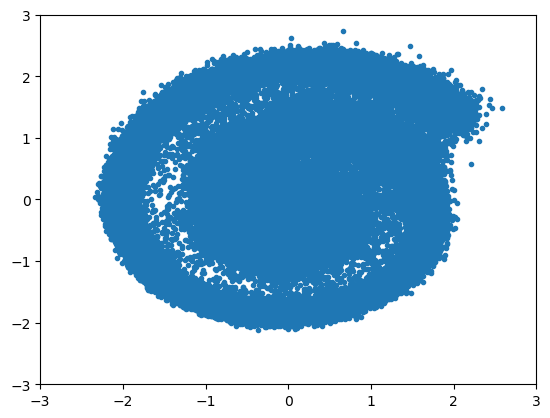

Model weights loaded successfully, computing last epoch loss.
KLD:  0.21266512028467036


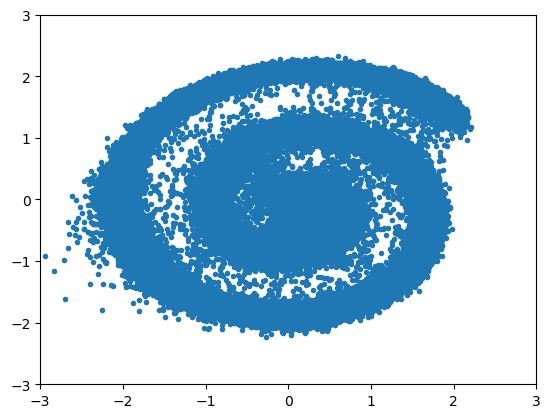

Model weights loaded successfully, computing last epoch loss.
KLD:  0.053714456202252986


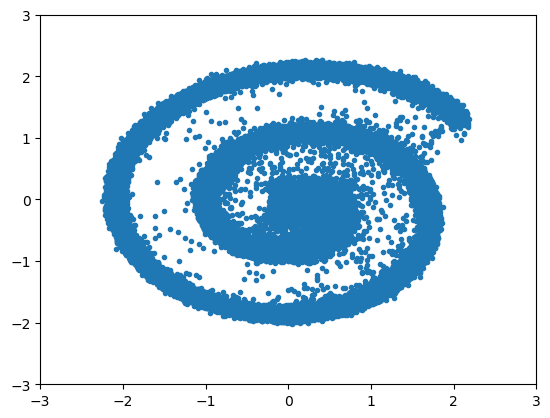

Model weights loaded successfully, computing last epoch loss.
KLD:  0.11616958257598513


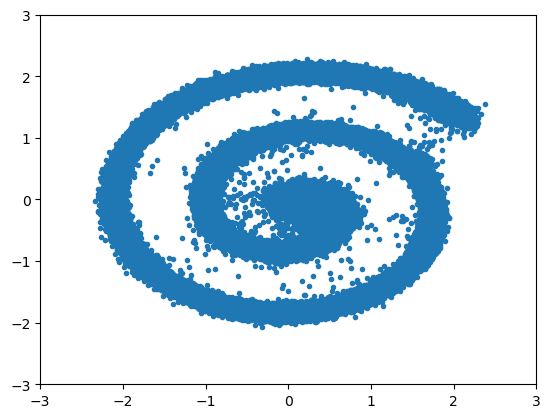

Model weights loaded successfully, computing last epoch loss.
KLD:  0.03479269154807248


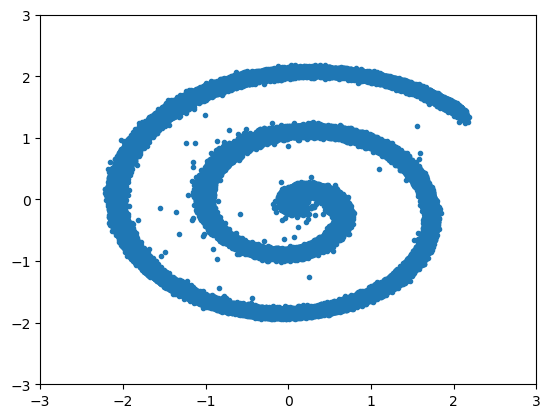

In [10]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, _ = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training = False

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, _ = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_labels = torch.zeros(train_data_length)
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                    channel_mult=[1,1,1,1,1,1], channel_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", channel_mult_noise=1)

    file_path = 'mdl_weights/train_len'+'_'+str(train_data_length)+'.pth'
    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses(model, vp, x)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found.") 
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses(model, vp, x)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = uncon_EulerMaruyama(1000, 1e-5, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    samples, _ = vp_sampler(model, vp, (sample_size, 2), device)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()

beta_min = 1E-4, beta_max = 0.5

data_len  beta_max  last_loss       fid   avg_nll       KLD

0       128       0.5   1.527598  0.003935  2.441617  1.252418

1       256       0.5   1.484637  0.008908  2.000243  0.681797

2       512       0.5   1.442207  0.005168  1.251309  0.315997

3      1024       0.5   1.441754  0.002447  1.060306  0.222362

4      2048       0.5   1.394354  0.002332  0.857369  0.110128

5      4096       0.5   1.390828  0.000849  0.769948  0.101179

6      8192       0.5   1.402370  0.001063  0.591049  0.041871

In [12]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss       fid   avg_nll       KLD     H Gen  \
0       128       0.5   1.470697  0.012649  2.480249  1.343470  2.555088   
1       256       0.5   1.498890  0.004612  2.002375  0.818183  2.076507   
2       512       0.5   1.466156  0.003965  1.364151  0.391948  1.637523   
3      1024       0.5   1.365325  0.002982  1.147364  0.212665  1.446676   
4      2048       0.5   1.354679  0.001282  0.655530  0.053714  1.288807   
5      4096       0.5   1.375877  0.000891  0.904097  0.116170  1.401201   
6      8192       0.5   1.361261  0.001388  0.602740  0.034793  1.237984   

     H True  
0  1.218089  
1  1.218089  
2  1.218089  
3  1.218089  
4  1.218089  
5  1.218089  
6  1.218089  


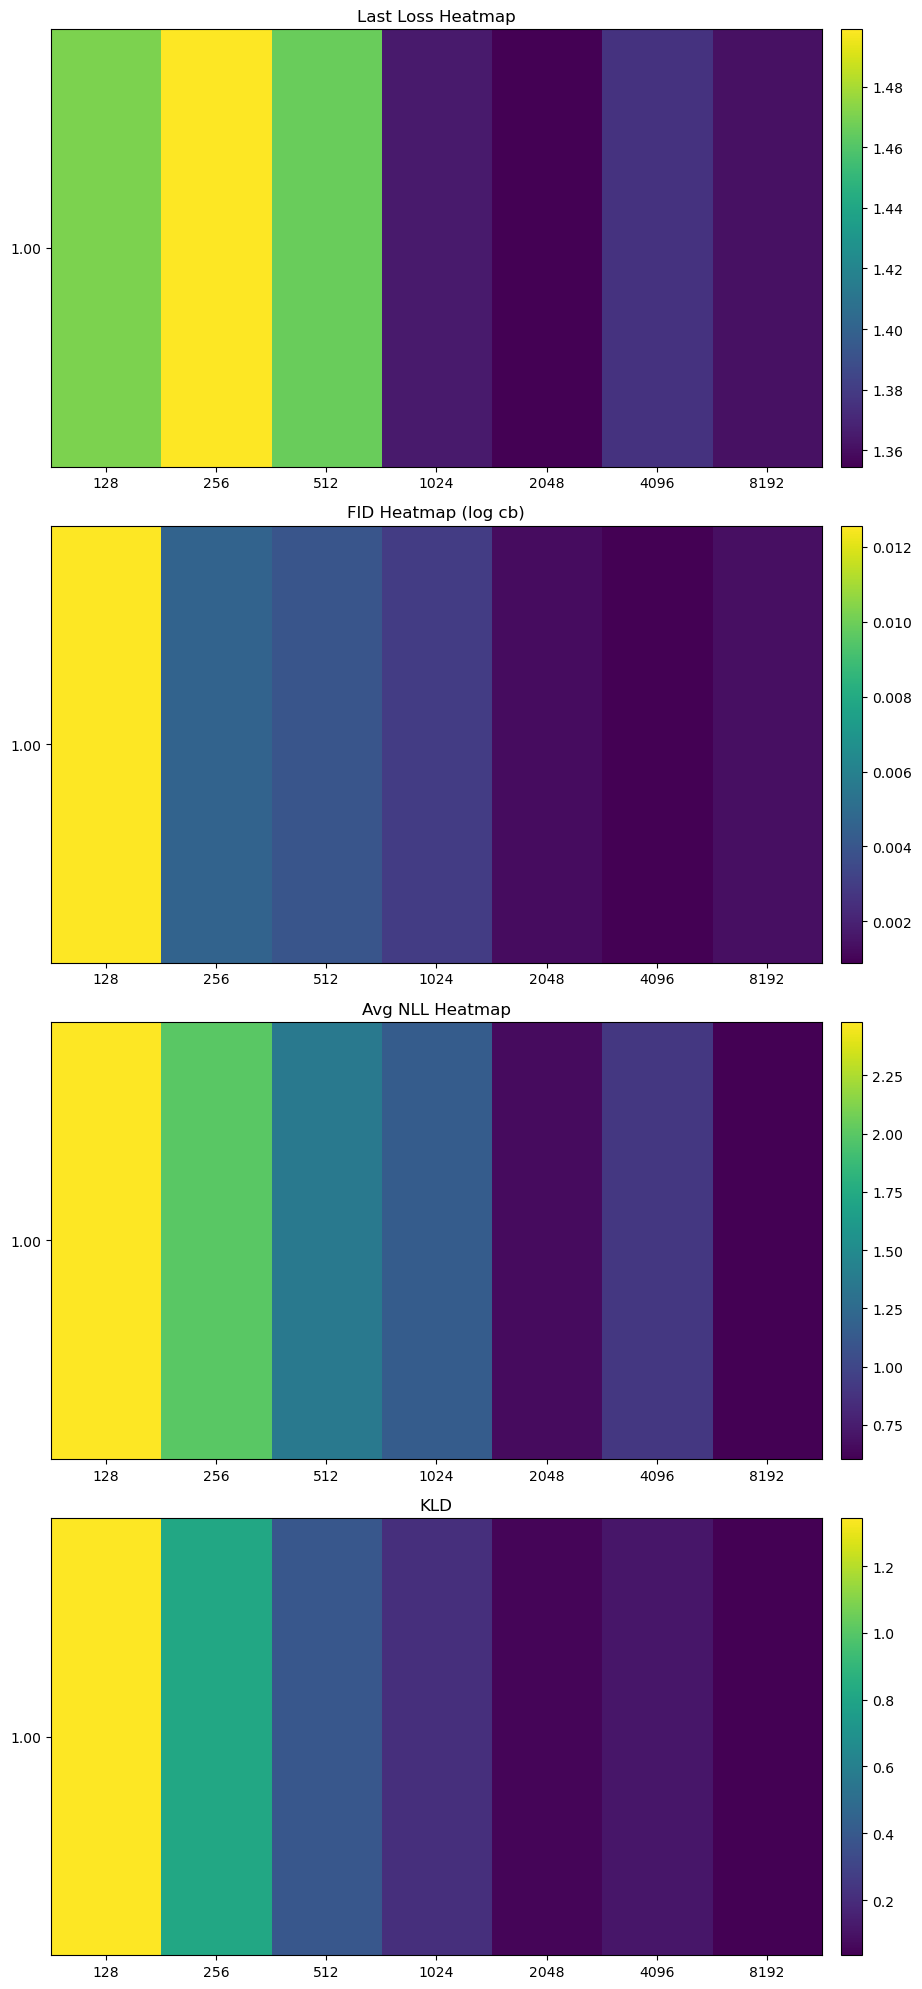

In [14]:
# Reshape columns to matrix form for heatmap
last_loss_matrix = results_df.pivot(index='beta_max', columns='data_len', values='last_loss').values
fid_matrix = results_df.pivot(index='beta_max', columns='data_len', values='fid').values
log_fid_matrix = np.log1p(fid_matrix)
avg_nll_matrix = results_df.pivot(index='beta_max', columns='data_len', values='avg_nll').values
KLD_matrix = results_df.pivot(index='beta_max', columns='data_len', values='KLD').values
beta_max_values=[1.]

# Plotting heatmaps
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# Last Loss heatmap
cax1 = ax[0].imshow(last_loss_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Last Loss Heatmap')
ax[0].set_yticks(np.arange(len(beta_max_values)))
ax[0].set_xticks(np.arange(len(train_len_vals)))
ax[0].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[0].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax1, ax=ax[0], orientation='vertical', pad=0.02)

# FID heatmap
cax2 = ax[1].imshow(log_fid_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('FID Heatmap (log cb)')
ax[1].set_yticks(np.arange(len(beta_max_values)))
ax[1].set_xticks(np.arange(len(train_len_vals)))
ax[1].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[1].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax2, ax=ax[1], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[2].imshow(avg_nll_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[2].set_title('Avg NLL Heatmap')
ax[2].set_yticks(np.arange(len(beta_max_values)))
ax[2].set_xticks(np.arange(len(train_len_vals)))
ax[2].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[2].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax3, ax=ax[2], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[3].imshow(KLD_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[3].set_title('KLD')
ax[3].set_yticks(np.arange(len(beta_max_values)))
ax[3].set_xticks(np.arange(len(train_len_vals)))
ax[3].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[3].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax3, ax=ax[3], orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

In [15]:
class EulerMaruyama(nn.Module):
    def __init__(self, 
                 num_time_steps=500, 
                 eps=1e-7,
                 intermediate_steps=100000):
        super().__init__()

        self.num_time_steps = num_time_steps
        self.eps = eps
        self.intermediate_steps = intermediate_steps

    @torch.no_grad()
    def predictor_step(self, x, t, c, step_size, unet, sde, device, cond_scale, rescaled_phi):
        mean_x = x - (sde.f(x, t) - sde.g(t)**2*unet(x, t, c, cond_scale=cond_scale, rescaled_phi=rescaled_phi, sampling=True))*step_size
        #mean_x = x - (sde.f(x, t) - sde.g(t)**2*unet(x, t, c, cond_drop_prob=0, sampling=True))*step_size
        x = mean_x + torch.sqrt(step_size)*sde.g(t)*torch.randn_like(x)
        return x, mean_x

    @torch.no_grad()
    def forward(self, unet, sde, data_size, device, cond_scale, rescaled_phi, return_intermediates=False):
        batch_size = data_size[0]
        noise = sde.sample_prior(data_size, device=device)
        time_steps = torch.linspace(1., self.eps, self.num_time_steps, device=device)
        step_size = time_steps[0]-time_steps[1]
        c = torch.rand(batch_size, device=device)*10-5

        x = noise + 0.
        intermediates = []
        i = 1
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            x, mean_x = self.predictor_step(x, batch_time_step, c, step_size, unet, sde, device, cond_scale, rescaled_phi)
            if i % self.intermediate_steps == 0:
                intermediates.append(x)
            i += 1

        # no noise in last step
        return mean_x, intermediates

class CondResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_channels, cond_emb_channels, dropout=0,
                 skip_scale=1, adaptive_scale=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_channels = time_emb_channels
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.linear = nn.Linear(out_channels, out_channels)
        self.affine = nn.Linear(time_emb_channels+cond_emb_channels, out_channels*(2 if adaptive_scale else 1))

    def forward(self, x, time_emb=None, cond_emb=None):
        #print(x.shape, emb.shape)
        orig = x
        emb = torch.cat((time_emb, cond_emb), dim = -1)
        params = nn.functional.silu(self.affine(emb).to(x.dtype))
        if self.adaptive_scale:
            scale, shift = params.chunk(2, dim=-1)
            x = nn.functional.silu(torch.addcmul(shift, x, scale+1))
        else:
            x = nn.functional.silu(x.add_(params))

        x = self.linear(nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = x.add_(orig)
        x = x * self.skip_scale

        return x

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model weights loaded successfully, computing last epoch loss.
KLD:  1.0109662013817613
Train data size: 128


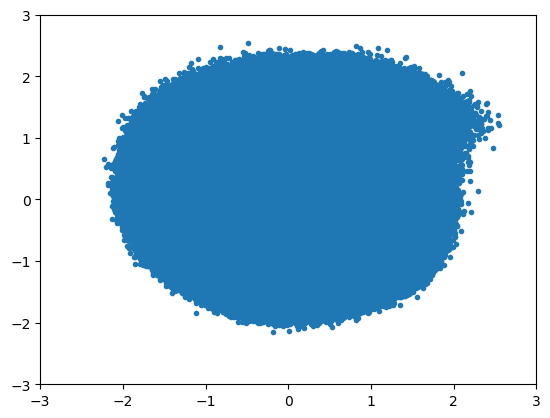

Model weights loaded successfully, computing last epoch loss.
KLD:  0.7156404382217658
Train data size: 256


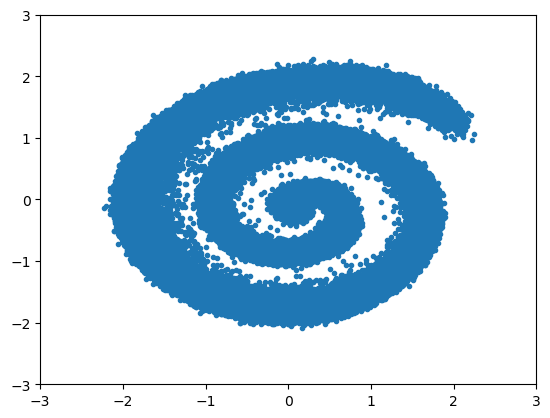

Model weights loaded successfully, computing last epoch loss.
KLD:  0.20446929066893696
Train data size: 512


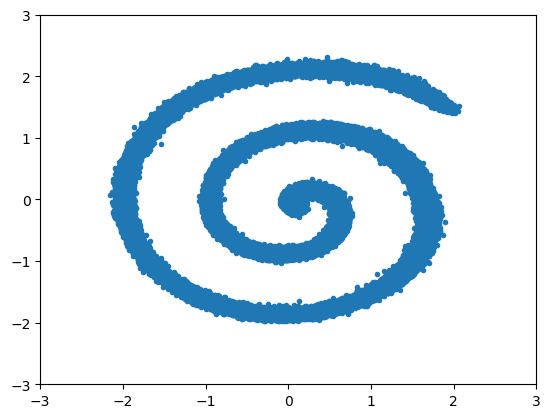

Model weights loaded successfully, computing last epoch loss.
KLD:  0.14507323001836614
Train data size: 1024


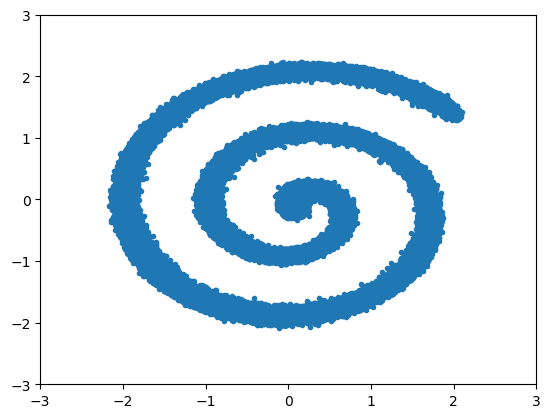

Model weights loaded successfully, computing last epoch loss.
KLD:  0.08678808398006864
Train data size: 2048


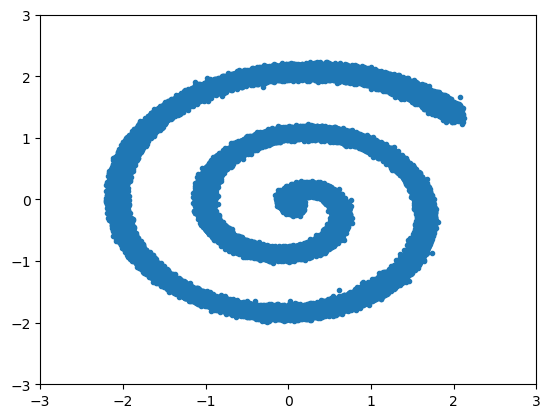

Model weights loaded successfully, computing last epoch loss.
KLD:  0.10653655825796093
Train data size: 4096


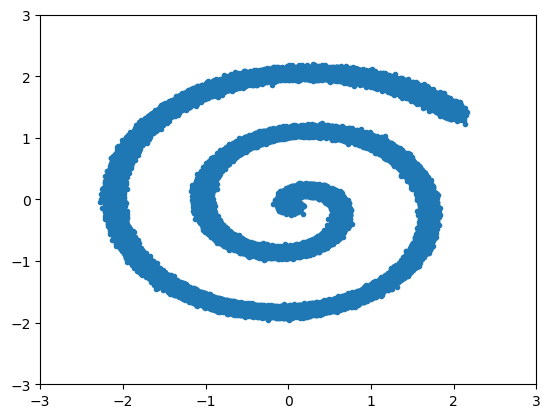

Model weights loaded successfully, computing last epoch loss.
KLD:  0.019839581070050055
Train data size: 8192


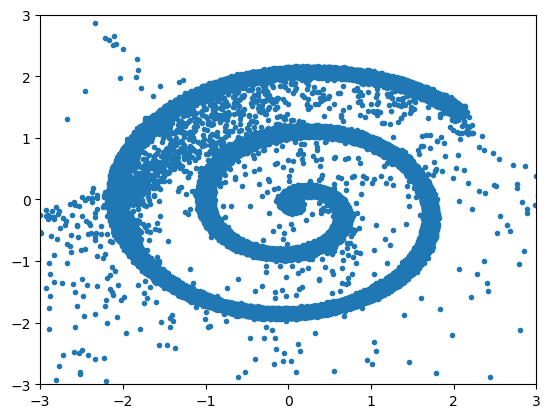

In [17]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =False

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CFGResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                    channel_mult=[1,1,1,1,1,1], channel_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", channel_mult_time=1, 
                    channel_mult_cond=1, cond_drop_prob=0)

    file_path = f'mdl_weights/uncon_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/uncon_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, cond_scale, rescaled_phi)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()

In [18]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss          fid       KLD     H Gen    H True
0       128       0.5   0.355100     0.046768  1.010966  1.838661  1.218089
1       256       0.5   0.268899     0.006521  0.715640  1.471506  1.218089
2       512       0.5   0.223962     0.002942  0.204469  1.235457  1.218089
3      1024       0.5   0.161292     0.001269  0.145073  1.329537  1.218089
4      2048       0.5   0.205507     0.000620  0.086788  1.302025  1.218089
5      4096       0.5   0.185176     0.000710  0.106537  1.277886  1.218089
6      8192       0.5   0.149894  8647.604374  0.019840  1.232902  1.218089


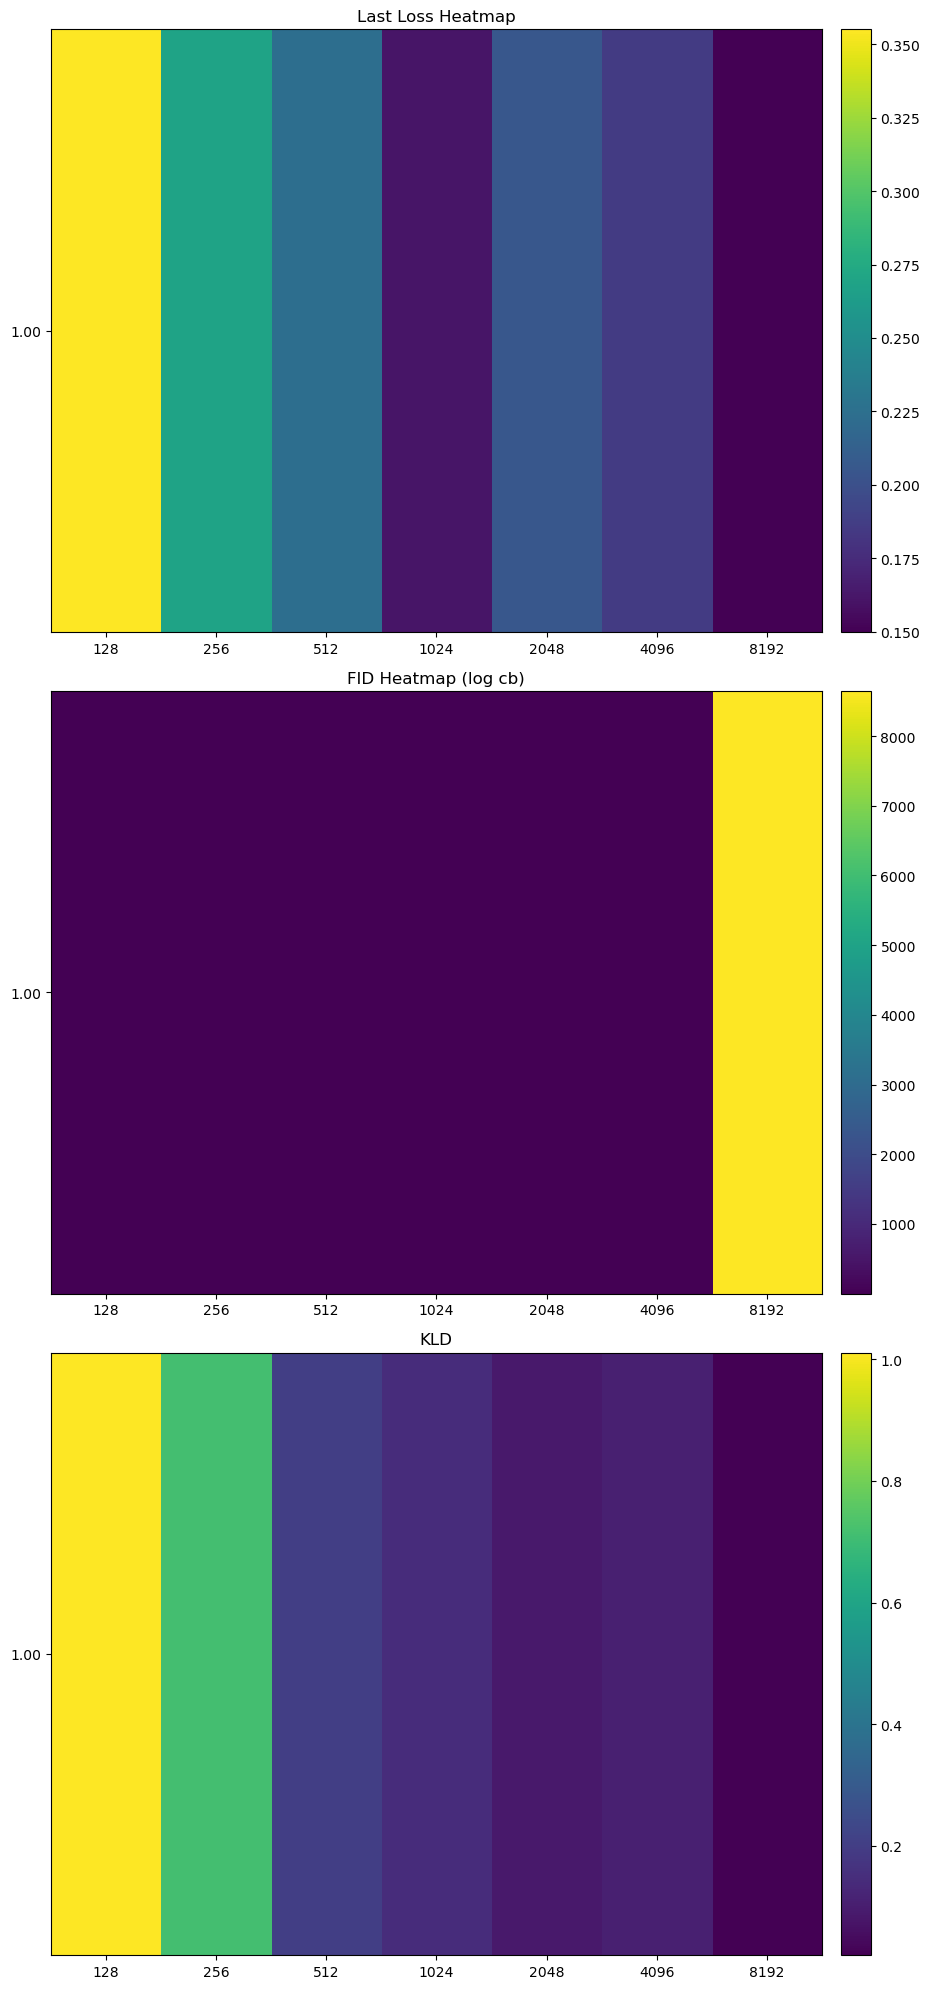

In [19]:
# Reshape columns to matrix form for heatmap
last_loss_matrix = results_df.pivot(index='beta_max', columns='data_len', values='last_loss').values
fid_matrix = results_df.pivot(index='beta_max', columns='data_len', values='fid').values
log_fid_matrix = np.log1p(fid_matrix)
#avg_nll_matrix = results_df.pivot(index='beta_max', columns='data_len', values='avg_nll').values
KLD_matrix = results_df.pivot(index='beta_max', columns='data_len', values='KLD').values
beta_max_values=[1.]

# Plotting heatmaps
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

# Last Loss heatmap
cax1 = ax[0].imshow(last_loss_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Last Loss Heatmap')
ax[0].set_yticks(np.arange(len(beta_max_values)))
ax[0].set_xticks(np.arange(len(train_len_vals)))
ax[0].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[0].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax1, ax=ax[0], orientation='vertical', pad=0.02)

# FID heatmap
cax2 = ax[1].imshow(fid_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('FID Heatmap (log cb)')
ax[1].set_yticks(np.arange(len(beta_max_values)))
ax[1].set_xticks(np.arange(len(train_len_vals)))
ax[1].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[1].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax2, ax=ax[1], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[2].imshow(KLD_matrix[:,:], aspect='auto', origin='lower', cmap='viridis')
ax[2].set_title('KLD')
ax[2].set_yticks(np.arange(len(beta_max_values)))
ax[2].set_xticks(np.arange(len(train_len_vals)))
ax[2].set_yticklabels([f"{val:.2f}" for val in beta_max_values])
ax[2].set_xticklabels([f"{val}" for val in train_len_vals])
fig.colorbar(cax3, ax=ax[2], orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()